## - Import

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import math
import torch.nn.functional as F

/home/hoge/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import random
import numpy as np
import torch

def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


torch_fix_seed()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 1.11.0+cu113
device: cuda


## - Parameters

In [4]:

img_size = 64 # Image size
batch_size = 16  # Batch size

# Model
z_size = 100
ngf = 32
ndf = 64
generator_layer_size = [256, 512, 1024, 2048]
discriminator_layer_size = [2048, 1024, 512, 256]

# Training
epochs = 100 # Train epochs
learning_rate_G = 2e-5
learning_rate_D = 1e-5

## - Pytorch Dataset, DataLoader: Fashion MNIST

In [5]:
class_list = [chr(i + 65) for i in range(26)]
class_num = len(class_list)

In [6]:
class ImageTransform():
  def __init__(self, mean, std):
    self.data_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize(mean, std)
    ])

  def __call__(self, img):
    return self.data_transform(img)

In [7]:
mean = (0.5,)
std = (0.5,)
images = ImageFolder( "../GoogleFonts/all", transform = ImageTransform(mean, std))
batch_size = 16
data_loader = DataLoader(images, batch_size = batch_size, shuffle = True, drop_last=True)

In [8]:
# print(dataset_GAN.X_train.shape)

# d = torch.from_numpy(dataset_GAN.X_train).float().clone()
# l = torch.from_numpy(dataset_GAN.y_train).long().clone()
# data_loader = zip(d, l)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


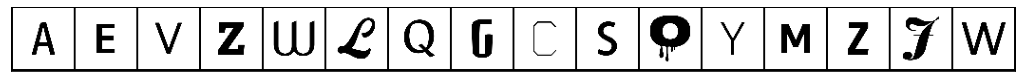

In [9]:
for images, labels in data_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

In [10]:
for images, labels in data_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [11]:
def onehot_encode(label, n_class=26):  
    # ラベルをOne-Hoe形式に変換
    eye = torch.eye(n_class).to(device)
    # ランダムベクトルあるいは画像と連結するために(B, c_class, 1, 1)のTensorにして戻す
    return eye[label].view(-1, n_class, 1, 1)
def concat_image_label(image, label, n_class=26):
    # 画像とラベルを連結する
    oh_label = onehot_encode(label).to(device)       # ラベルをOne-Hot形式に変換
    oh_label = oh_label.expand(16, n_class, 64, 64)  # ラベルを画像サイズに拡大
    return torch.cat((image, oh_label), dim=1)    # 画像とラベルをチャネル方向（dim=1）で連結
 
def concat_noise_label(noise, label):
    # ランダムベクトルとラベルを連結する
    oh_label = onehot_encode(label).to(device)     # ラベルをOne-Hot形式に変換
    return torch.cat((noise, oh_label), dim=1)  # ランダムベクトルとラベルを連結

## - Generator

In [12]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()
        
        self.z_size = z_size
        self.img_size = img_size
        
        # self.label_emb = nn.Embedding(class_num, class_num)
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(self.z_size + 26, ngf * 32, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 32),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 32, ngf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, 1, 3, 1, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        
        # Reshape z
        # z = z.view(-1, self.z_size)
        
        # One-hot vector to embedding vector
        # c = self.label_emb(labels)
        
        # Concat image & label
        # x = torch.cat([z, c], 1)

        x = concat_noise_label(z, labels)

        
        # Generator out
        out = self.model(x)
        
        return out
        # return out.view(-1, self.img_size, self.img_size)

## - Discriminator

In [13]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()
        
        # self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size
        
        self.model = nn.Sequential(
            nn.Conv2d(27, ndf, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, ndf * 8, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 8, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        
        # Reshape fake image
        # x = x.view(-1, self.img_size * self.img_size)
        
        # One-hot vector to embedding vector
        # c = self.label_emb(labels)
    
        # Concat image & label
        # x = torch.cat([x, c], 1)

        x = concat_image_label(x, labels)
        
        # Discriminator out
        
        out = self.model(x)
        
        return out.squeeze()

In [14]:
# Define generator
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
# 使うデバイス（CPUかGPUか）の定義
model_list = []
for i in range(26):
    pretrained_model = "../normalPGD_reg_dataset/model/reg_" + chr(i + 65) + ".pth"
    # ネットワークの初期化
    model = Net().to(device)
    # 訓練済みモデルのロード
    model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
    # モデルを評価モードに設定。本チュートリアルの例では、これはドロップアウト層等を評価モードにするのに必要
    model.eval()
    model_list.append(model)

## - Adversarial Learning of Generator & Discriminator

In [16]:
# Loss function
criterion = nn.BCELoss()
criterion_r = nn.MSELoss()

In [17]:
# Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate_G)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate_D)

In [18]:
class DynamicWeight:

    def __init__(self, init_weight=0.1, L1_x=None, L1_y=None, L2_x=None, L2_y=None):
        self.init_weight = init_weight
        self.L1_x = L1_x
        self.L1_y = L1_y
        self.L2_x = L2_x
        self.L2_y = L2_y
        self.x_list = []
        self.y_list = []

    def calc_ratio(self, L1_x, L1_y, L2_x, L2_y):
        e = math.e

        w_x = L2_x / L1_x
        w_y = L2_y / L1_y
        
        e_x = e ** w_x
        e_y = e ** w_y
        
        r_x = e_x / (e_x + e_y)
        r_y = e_y / (e_x + e_y)

        return r_x, r_y

    def __call__(self, loss_x, loss_y):
        self.x_list.append(loss_x)
        self.y_list.append(loss_y)

        if self.L2_x is None:
            self.L2_x = self.L1_x
            self.L2_y = self.L1_y
            self.L1_x = loss_x
            self.L1_y = loss_y
            return 1, self.init_weight
        
        else:
            r_x, r_y = self.calc_ratio(self.L1_x, self.L1_y, self.L2_x, self.L2_y)
            self.L2_x = self.L1_x
            self.L2_y = self.L1_y
            self.L1_x = loss_x
            self.L1_y = loss_y
            return r_x, r_y

    def plot(self):
        return self.x_list, self.y_list

In [19]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    
    # Init gradient
    g_optimizer.zero_grad()

    # Building z
    # z1 = torch.rand((batch_size, z_size))
    # z2 = (torch.randn((batch_size, z_size)) > 0) * 2 - 1
    # z = Variable(torch.mul(z1, z2)).to(device)
    z = Variable(torch.randn(batch_size, z_size, 1, 1)).to(device)

    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)

    # Generating fake images
    fake_images = generator(z, fake_labels)

    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)

    # Calculating discrimination loss (fake images)
    loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    
    # Backword propagation
    loss.backward()

    #  Optimizing generator
    g_optimizer.step()

    return loss.data.cpu()

In [20]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
  # Init gradient 
  d_optimizer.zero_grad()

  # Disciminating real images
  real_validity = discriminator(real_images, labels)

  # Calculating discrimination loss (real images)
  real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))

  # Building z
  # z1 = torch.rand((batch_size, z_size))
  # z2 = (torch.randn((batch_size, z_size)) > 0) * 2 - 1
  # z = Variable(torch.mul(z1, z2)).to(device)
  z = Variable(torch.randn(batch_size, z_size, 1, 1)).to(device)

  # Building fake labels
  fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)

  # Generating fake images
  fake_images = generator(z, fake_labels)

  # Disciminating fake images
  fake_validity = discriminator(fake_images, fake_labels)

  # Calculating discrimination loss (fake images)
  fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))

  # Sum two losses
  loss = real_loss + fake_loss

  # Backword propagation
  loss.backward()

  # Optimizing discriminator
  d_optimizer.step()

  return loss.data.cpu()

Starting epoch 1...


100%|██████████| 4116/4116 [04:15<00:00, 16.14it/s]


G_loss: 3.871652364730835, D_loss: 0.2633291482925415


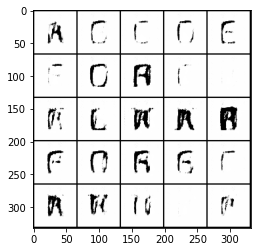

Starting epoch 2...


100%|██████████| 4116/4116 [04:20<00:00, 15.77it/s]


G_loss: 3.3307881355285645, D_loss: 0.39473292231559753


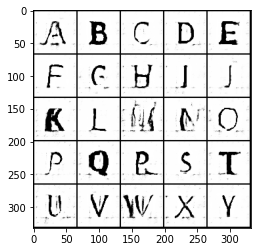

Starting epoch 3...


100%|██████████| 4116/4116 [04:16<00:00, 16.02it/s]


G_loss: 4.229786396026611, D_loss: 0.2754944860935211


Starting epoch 4...


100%|██████████| 4116/4116 [04:13<00:00, 16.22it/s]


G_loss: 7.614668846130371, D_loss: 0.021412840113043785


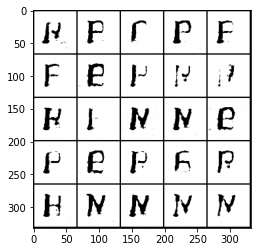

Starting epoch 5...


100%|██████████| 4116/4116 [04:04<00:00, 16.83it/s]


G_loss: 3.813525438308716, D_loss: 0.3668718636035919


Starting epoch 6...


100%|██████████| 4116/4116 [03:58<00:00, 17.24it/s]


G_loss: 2.4998419284820557, D_loss: 0.5122495889663696


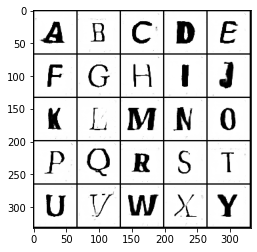

Starting epoch 7...


100%|██████████| 4116/4116 [03:59<00:00, 17.20it/s]


G_loss: 2.536011219024658, D_loss: 0.49854227900505066


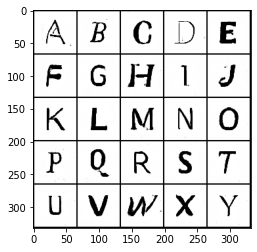

Starting epoch 8...


100%|██████████| 4116/4116 [03:59<00:00, 17.17it/s]


G_loss: 2.508080244064331, D_loss: 0.5186792612075806


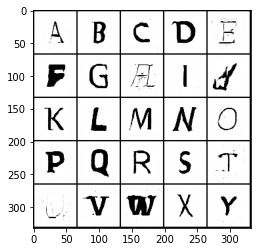

Starting epoch 9...


100%|██████████| 4116/4116 [03:56<00:00, 17.37it/s]


G_loss: 2.590144157409668, D_loss: 0.5034477114677429


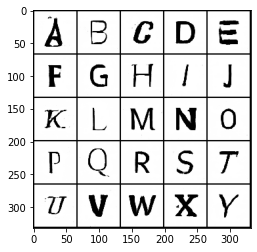

Starting epoch 10...


100%|██████████| 4116/4116 [03:56<00:00, 17.38it/s]


G_loss: 2.592778205871582, D_loss: 0.5061061382293701


Starting epoch 11...


100%|██████████| 4116/4116 [03:58<00:00, 17.25it/s]


G_loss: 2.6544294357299805, D_loss: 0.48578041791915894


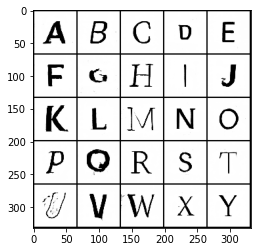

Starting epoch 12...


100%|██████████| 4116/4116 [04:01<00:00, 17.05it/s]


G_loss: 2.6802210807800293, D_loss: 0.4855509102344513


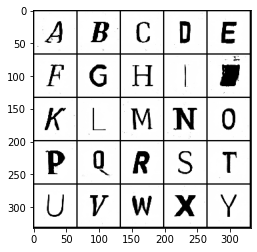

Starting epoch 13...


100%|██████████| 4116/4116 [04:04<00:00, 16.84it/s]


G_loss: 2.791141986846924, D_loss: 0.4820176064968109


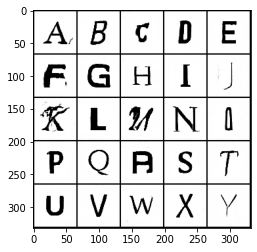

Starting epoch 14...


100%|██████████| 4116/4116 [04:00<00:00, 17.14it/s]


G_loss: 2.8064236640930176, D_loss: 0.46087363362312317


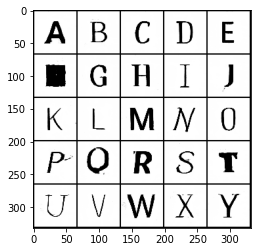

Starting epoch 15...


100%|██████████| 4116/4116 [04:00<00:00, 17.14it/s]


G_loss: 3.0641210079193115, D_loss: 0.40910714864730835


Starting epoch 16...


100%|██████████| 4116/4116 [03:59<00:00, 17.21it/s]


G_loss: 3.2682580947875977, D_loss: 0.3640810549259186


Starting epoch 17...


100%|██████████| 4116/4116 [04:06<00:00, 16.67it/s]


G_loss: 3.601304292678833, D_loss: 0.31965458393096924


Starting epoch 18...


100%|██████████| 4116/4116 [04:01<00:00, 17.07it/s]


G_loss: 3.7496559619903564, D_loss: 0.3092418313026428


Starting epoch 19...


100%|██████████| 4116/4116 [03:58<00:00, 17.27it/s]


G_loss: 3.9503414630889893, D_loss: 0.28186383843421936


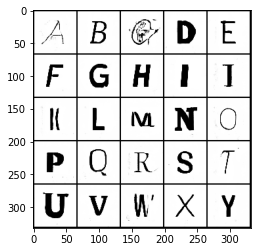

Starting epoch 20...


100%|██████████| 4116/4116 [04:14<00:00, 16.19it/s]


G_loss: 4.0738749504089355, D_loss: 0.25522133708000183


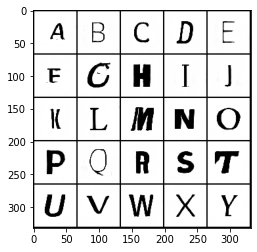

Starting epoch 21...


100%|██████████| 4116/4116 [03:56<00:00, 17.39it/s]


G_loss: 4.235542297363281, D_loss: 0.2478359192609787


Starting epoch 22...


100%|██████████| 4116/4116 [03:54<00:00, 17.55it/s]


G_loss: 4.060543060302734, D_loss: 0.2501254975795746


Starting epoch 23...


100%|██████████| 4116/4116 [03:58<00:00, 17.25it/s]


G_loss: 4.413694381713867, D_loss: 0.22249288856983185


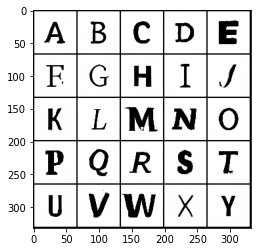

Starting epoch 24...


100%|██████████| 4116/4116 [04:03<00:00, 16.91it/s]


G_loss: 4.32761287689209, D_loss: 0.2515811324119568


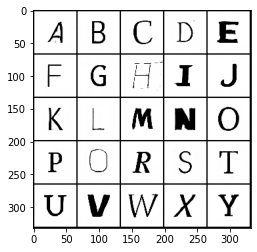

Starting epoch 25...


100%|██████████| 4116/4116 [04:09<00:00, 16.51it/s]


G_loss: 4.407904148101807, D_loss: 0.22200103104114532


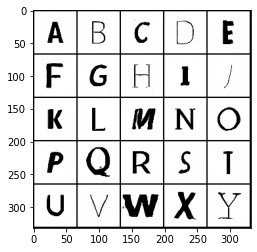

Starting epoch 26...


100%|██████████| 4116/4116 [03:54<00:00, 17.52it/s]


G_loss: 4.4962944984436035, D_loss: 0.21242819726467133


Starting epoch 27...


100%|██████████| 4116/4116 [03:55<00:00, 17.50it/s]


G_loss: 4.553143501281738, D_loss: 0.21493805944919586


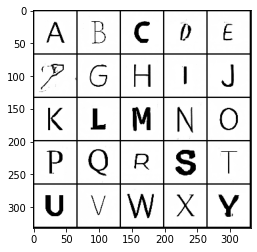

Starting epoch 28...


100%|██████████| 4116/4116 [03:55<00:00, 17.45it/s]


G_loss: 4.752761363983154, D_loss: 0.19219520688056946


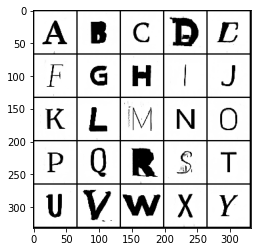

Starting epoch 29...


100%|██████████| 4116/4116 [03:54<00:00, 17.59it/s]


G_loss: 4.632871150970459, D_loss: 0.2008838951587677


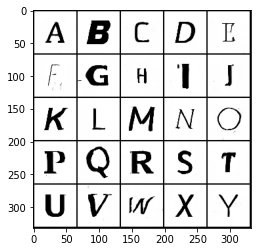

Starting epoch 30...


100%|██████████| 4116/4116 [04:07<00:00, 16.60it/s]


G_loss: 4.6734938621521, D_loss: 0.211359441280365


Starting epoch 31...


100%|██████████| 4116/4116 [04:01<00:00, 17.02it/s]


G_loss: 4.76110315322876, D_loss: 0.20113833248615265


Starting epoch 32...


100%|██████████| 4116/4116 [04:00<00:00, 17.13it/s]


G_loss: 4.759533882141113, D_loss: 0.2009323239326477


Starting epoch 33...


100%|██████████| 4116/4116 [03:54<00:00, 17.53it/s]


G_loss: 4.943023681640625, D_loss: 0.17905151844024658


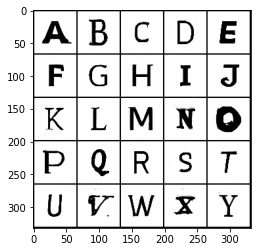

Starting epoch 34...


100%|██████████| 4116/4116 [03:54<00:00, 17.58it/s]


G_loss: 5.01262903213501, D_loss: 0.1814766228199005


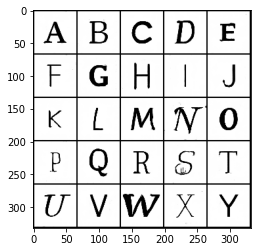

Starting epoch 35...


100%|██████████| 4116/4116 [04:08<00:00, 16.53it/s]


G_loss: 5.009995937347412, D_loss: 0.1769891083240509


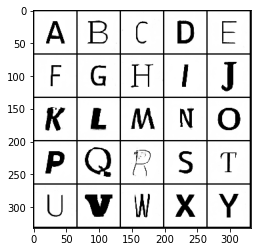

Starting epoch 36...


100%|██████████| 4116/4116 [03:56<00:00, 17.42it/s]


G_loss: 5.104963779449463, D_loss: 0.16547885537147522


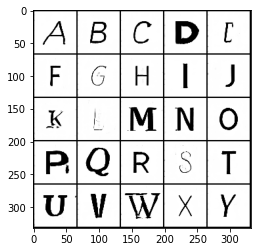

Starting epoch 37...


100%|██████████| 4116/4116 [03:56<00:00, 17.40it/s]


G_loss: 5.139255523681641, D_loss: 0.16732394695281982


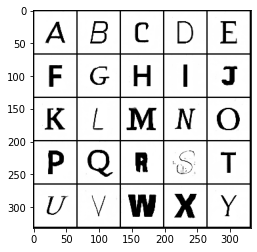

Starting epoch 38...


100%|██████████| 4116/4116 [03:55<00:00, 17.48it/s]


G_loss: 5.253215789794922, D_loss: 0.1608767807483673


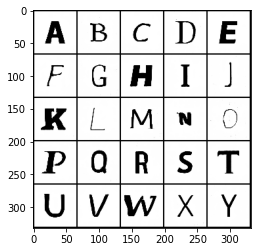

Starting epoch 39...


100%|██████████| 4116/4116 [03:55<00:00, 17.47it/s]


G_loss: 5.24773645401001, D_loss: 0.1601574569940567


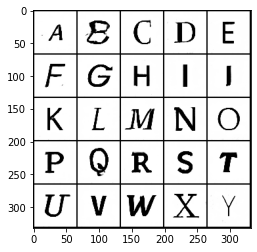

Starting epoch 40...


100%|██████████| 4116/4116 [03:54<00:00, 17.53it/s]


G_loss: 5.4508490562438965, D_loss: 0.13846711814403534


Starting epoch 41...


100%|██████████| 4116/4116 [04:00<00:00, 17.15it/s]


G_loss: 5.4419989585876465, D_loss: 0.15486940741539001


Starting epoch 42...


100%|██████████| 4116/4116 [03:54<00:00, 17.53it/s]


G_loss: 5.469578742980957, D_loss: 0.1538577824831009


Starting epoch 43...


100%|██████████| 4116/4116 [03:56<00:00, 17.42it/s]


G_loss: 5.5282158851623535, D_loss: 0.1410265564918518


Starting epoch 44...


100%|██████████| 4116/4116 [03:55<00:00, 17.45it/s]


G_loss: 5.524419784545898, D_loss: 0.16247627139091492


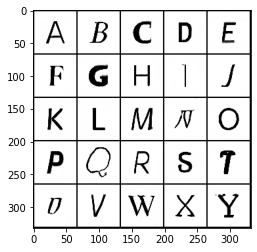

Starting epoch 45...


100%|██████████| 4116/4116 [04:01<00:00, 17.04it/s]


G_loss: 5.512509346008301, D_loss: 0.1404217779636383


Starting epoch 46...


100%|██████████| 4116/4116 [03:57<00:00, 17.32it/s]


G_loss: 5.592853546142578, D_loss: 0.13272765278816223


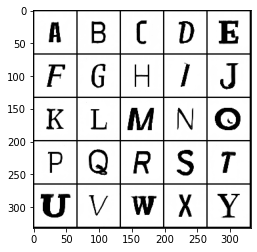

Starting epoch 47...


100%|██████████| 4116/4116 [03:57<00:00, 17.31it/s]


G_loss: 5.739549160003662, D_loss: 0.1309380978345871


Starting epoch 48...


100%|██████████| 4116/4116 [03:54<00:00, 17.54it/s]


G_loss: 5.792246341705322, D_loss: 0.13785141706466675


Starting epoch 49...


100%|██████████| 4116/4116 [03:59<00:00, 17.18it/s]


G_loss: 5.677793025970459, D_loss: 0.1276295781135559


Starting epoch 50...


100%|██████████| 4116/4116 [03:59<00:00, 17.20it/s]


G_loss: 5.903078556060791, D_loss: 0.1247899979352951


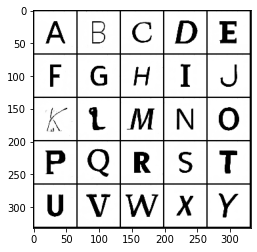

Starting epoch 51...


100%|██████████| 4116/4116 [03:59<00:00, 17.19it/s]


G_loss: 5.799990653991699, D_loss: 0.13952817022800446


Starting epoch 52...


100%|██████████| 4116/4116 [03:56<00:00, 17.43it/s]


G_loss: 6.1029253005981445, D_loss: 0.1053553968667984


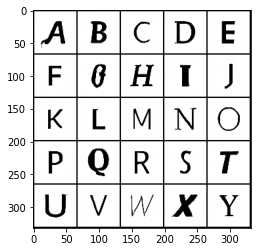

Starting epoch 53...


100%|██████████| 4116/4116 [04:03<00:00, 16.93it/s]


G_loss: 6.123039245605469, D_loss: 0.12320972234010696


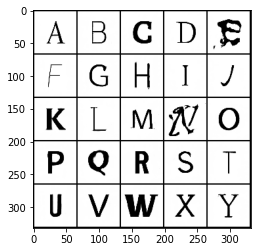

Starting epoch 54...


100%|██████████| 4116/4116 [04:03<00:00, 16.91it/s]


G_loss: 6.034266948699951, D_loss: 0.11384227126836777


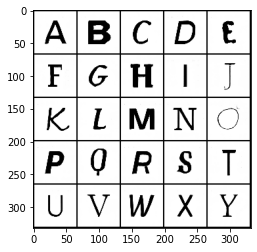

Starting epoch 55...


100%|██████████| 4116/4116 [04:03<00:00, 16.92it/s]


G_loss: 6.1719536781311035, D_loss: 0.12078557908535004


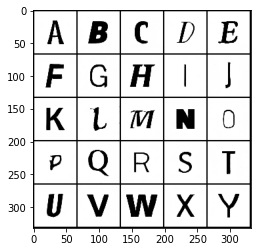

Starting epoch 56...


100%|██████████| 4116/4116 [03:56<00:00, 17.42it/s]


G_loss: 6.174864768981934, D_loss: 0.10855934768915176


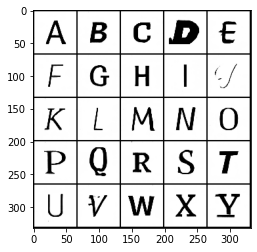

Starting epoch 57...


100%|██████████| 4116/4116 [03:55<00:00, 17.45it/s]


G_loss: 6.343522071838379, D_loss: 0.11578873544931412


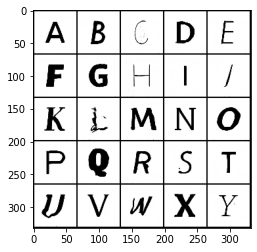

Starting epoch 58...


100%|██████████| 4116/4116 [03:58<00:00, 17.24it/s]


G_loss: 6.131591320037842, D_loss: 0.1146811991930008


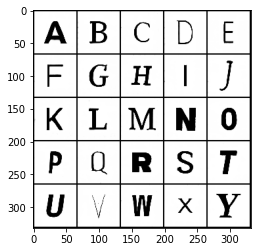

Starting epoch 59...


100%|██████████| 4116/4116 [03:59<00:00, 17.20it/s]


G_loss: 6.210663318634033, D_loss: 0.11396969109773636


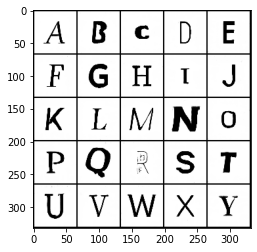

Starting epoch 60...


100%|██████████| 4116/4116 [03:55<00:00, 17.48it/s]


G_loss: 6.212265491485596, D_loss: 0.11867694556713104


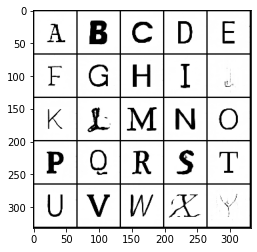

Starting epoch 61...


100%|██████████| 4116/4116 [03:59<00:00, 17.15it/s]


G_loss: 6.40678596496582, D_loss: 0.10372724384069443


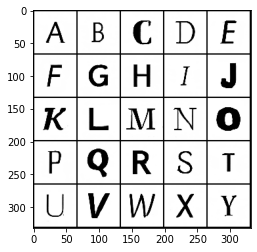

Starting epoch 62...


100%|██████████| 4116/4116 [03:53<00:00, 17.65it/s]


G_loss: 6.625354290008545, D_loss: 0.09121891111135483


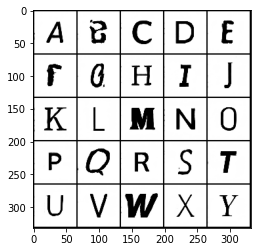

Starting epoch 63...


100%|██████████| 4116/4116 [03:58<00:00, 17.26it/s]


G_loss: 6.405196666717529, D_loss: 0.1016237735748291


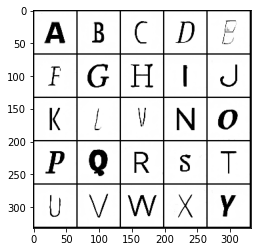

Starting epoch 64...


100%|██████████| 4116/4116 [04:01<00:00, 17.07it/s]


G_loss: 6.4233784675598145, D_loss: 0.10345344245433807


Starting epoch 65...


100%|██████████| 4116/4116 [03:55<00:00, 17.50it/s]


G_loss: 6.474354267120361, D_loss: 0.09852468967437744


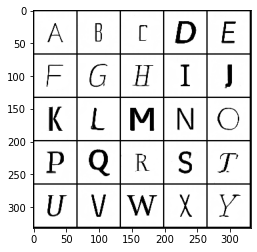

Starting epoch 66...


100%|██████████| 4116/4116 [03:53<00:00, 17.63it/s]


G_loss: 6.492755889892578, D_loss: 0.09601210057735443


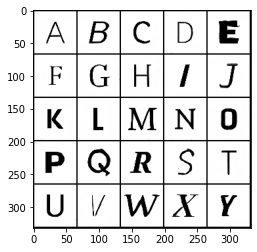

Starting epoch 67...


100%|██████████| 4116/4116 [03:56<00:00, 17.38it/s]


G_loss: 6.554037570953369, D_loss: 0.10105644166469574


Starting epoch 68...


100%|██████████| 4116/4116 [03:54<00:00, 17.52it/s]


G_loss: 6.538509368896484, D_loss: 0.10795464366674423


Starting epoch 69...


100%|██████████| 4116/4116 [03:58<00:00, 17.22it/s]


G_loss: 6.6867899894714355, D_loss: 0.07630856335163116


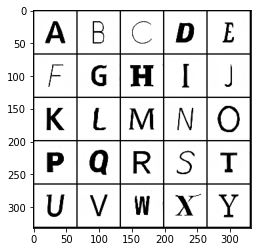

Starting epoch 70...


100%|██████████| 4116/4116 [04:00<00:00, 17.09it/s]


G_loss: 6.568241596221924, D_loss: 0.10019765794277191


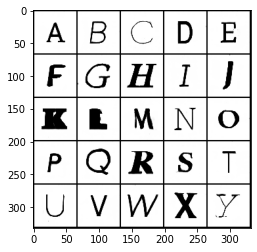

Starting epoch 71...


100%|██████████| 4116/4116 [03:55<00:00, 17.50it/s]


G_loss: 6.506625175476074, D_loss: 0.09962669759988785


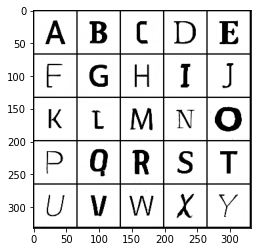

Starting epoch 72...


100%|██████████| 4116/4116 [03:56<00:00, 17.39it/s]


G_loss: 6.637214183807373, D_loss: 0.09597643464803696


Starting epoch 73...


100%|██████████| 4116/4116 [03:57<00:00, 17.34it/s]


G_loss: 6.5930962562561035, D_loss: 0.09422089904546738


Starting epoch 74...


100%|██████████| 4116/4116 [03:58<00:00, 17.22it/s]


G_loss: 6.730596542358398, D_loss: 0.08708475530147552


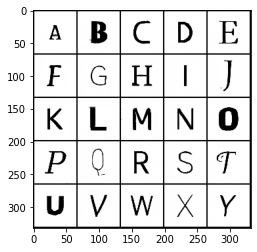

Starting epoch 75...


100%|██████████| 4116/4116 [04:00<00:00, 17.10it/s]


G_loss: 6.753110885620117, D_loss: 0.08629737794399261


Starting epoch 76...


100%|██████████| 4116/4116 [04:25<00:00, 15.50it/s]


G_loss: 6.810485363006592, D_loss: 0.09119567275047302


Starting epoch 77...


100%|██████████| 4116/4116 [04:01<00:00, 17.05it/s]


G_loss: 6.700736999511719, D_loss: 0.0930861309170723


Starting epoch 78...


100%|██████████| 4116/4116 [04:19<00:00, 15.87it/s]


G_loss: 7.057877540588379, D_loss: 0.08610282093286514


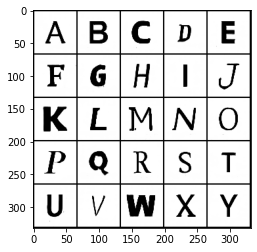

Starting epoch 79...


100%|██████████| 4116/4116 [04:00<00:00, 17.15it/s]


G_loss: 6.881356716156006, D_loss: 0.09142067283391953


Starting epoch 80...


100%|██████████| 4116/4116 [03:56<00:00, 17.39it/s]


G_loss: 6.831959247589111, D_loss: 0.08433787524700165


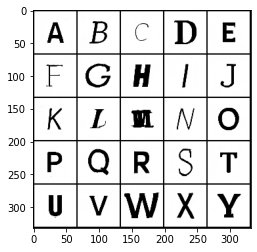

Starting epoch 81...


100%|██████████| 4116/4116 [03:59<00:00, 17.22it/s]


G_loss: 6.832630157470703, D_loss: 0.09141309559345245


Starting epoch 82...


100%|██████████| 4116/4116 [03:57<00:00, 17.30it/s]


G_loss: 7.0953145027160645, D_loss: 0.0753946378827095


Starting epoch 83...


100%|██████████| 4116/4116 [04:00<00:00, 17.10it/s]


G_loss: 6.778153896331787, D_loss: 0.09366831928491592


Starting epoch 84...


100%|██████████| 4116/4116 [03:58<00:00, 17.27it/s]


G_loss: 6.918954849243164, D_loss: 0.07995406538248062


Starting epoch 85...


100%|██████████| 4116/4116 [03:55<00:00, 17.46it/s]


G_loss: 7.050151824951172, D_loss: 0.08443854749202728


Starting epoch 86...


100%|██████████| 4116/4116 [04:01<00:00, 17.08it/s]


G_loss: 6.987824440002441, D_loss: 0.08182849735021591


Starting epoch 87...


100%|██████████| 4116/4116 [03:55<00:00, 17.48it/s]


G_loss: 6.858713626861572, D_loss: 0.08788266777992249


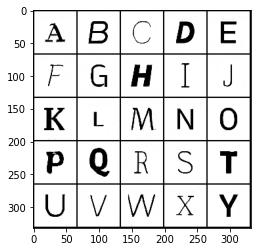

Starting epoch 88...


100%|██████████| 4116/4116 [03:57<00:00, 17.30it/s]


G_loss: 6.914588451385498, D_loss: 0.08869463950395584


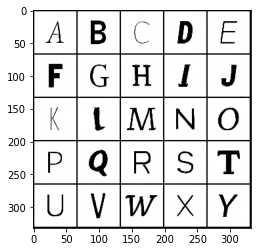

Starting epoch 89...


100%|██████████| 4116/4116 [04:00<00:00, 17.11it/s]


G_loss: 7.001863956451416, D_loss: 0.08615942299365997


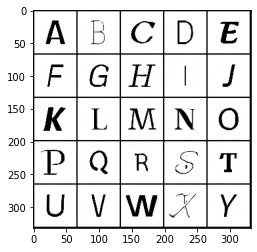

Starting epoch 90...


100%|██████████| 4116/4116 [03:57<00:00, 17.33it/s]


G_loss: 7.065683841705322, D_loss: 0.08802176266908646


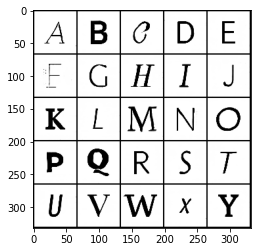

Starting epoch 91...


100%|██████████| 4116/4116 [04:00<00:00, 17.11it/s]


G_loss: 6.891729831695557, D_loss: 0.08720938861370087


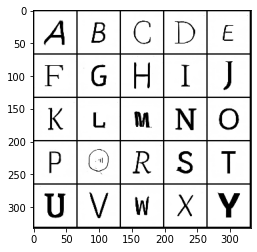

Starting epoch 92...


100%|██████████| 4116/4116 [03:57<00:00, 17.34it/s]


G_loss: 6.9986701011657715, D_loss: 0.0763983279466629


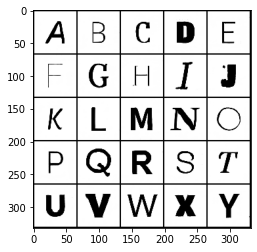

Starting epoch 93...


100%|██████████| 4116/4116 [03:58<00:00, 17.29it/s]


G_loss: 7.246574878692627, D_loss: 0.07932674884796143


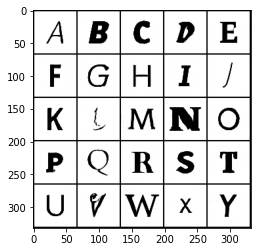

Starting epoch 94...


100%|██████████| 4116/4116 [04:05<00:00, 16.73it/s]


G_loss: 7.012067794799805, D_loss: 0.08850494772195816


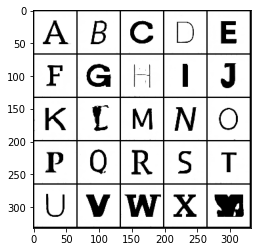

Starting epoch 95...


100%|██████████| 4116/4116 [03:54<00:00, 17.57it/s]


G_loss: 7.041161060333252, D_loss: 0.0762002095580101


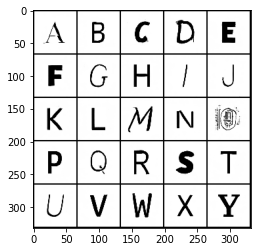

Starting epoch 96...


100%|██████████| 4116/4116 [04:02<00:00, 16.94it/s]


G_loss: 7.262194633483887, D_loss: 0.0766785740852356


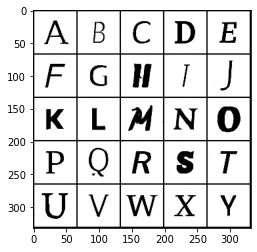

Starting epoch 97...


100%|██████████| 4116/4116 [03:57<00:00, 17.30it/s]


G_loss: 7.248080253601074, D_loss: 0.07434766739606857


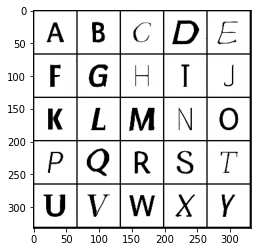

Starting epoch 98...


100%|██████████| 4116/4116 [04:00<00:00, 17.11it/s]


G_loss: 7.243255138397217, D_loss: 0.07628477364778519


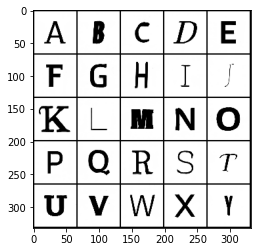

Starting epoch 99...


100%|██████████| 4116/4116 [03:56<00:00, 17.42it/s]


G_loss: 7.151571273803711, D_loss: 0.07520709931850433


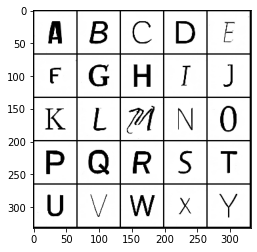

Starting epoch 100...


100%|██████████| 4116/4116 [03:57<00:00, 17.33it/s]


G_loss: 7.451682090759277, D_loss: 0.07861274480819702


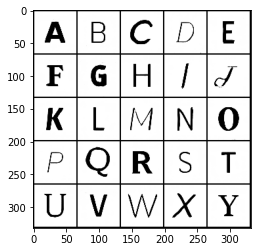

In [21]:
history = []
for epoch in range(epochs):
    print('Starting epoch {}...'.format(epoch+1))
    G_losses, D_losses = [], []
    for images, labels in tqdm(data_loader):
        # Train data
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        # Set generator train
        generator.train()

        # Train discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        
        # Train generator
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

        G_losses.append(g_loss)
        D_losses.append(d_loss)
   
    info = {
            "epoch": epoch + 1,
            "G_loss": np.mean(G_losses),
            "D_loss": np.mean(D_losses),
            }
    history.append(info)
    torch.save(generator.state_dict(), "generator.pth")
    torch.save(discriminator.state_dict(), "discriminator.pth")
    # Set generator eval
    generator.eval()
    print('G_loss: {}, D_loss: {}'.format(np.mean(G_losses), np.mean(D_losses)))
    
    # Building z 
    # z1 = torch.rand((class_num - 1, z_size))
    # z2 = (torch.randn((class_num - 1, z_size)) > 0) * 2 - 1
    # z = Variable(torch.mul(z1, z2)).to(device)
    z = Variable(torch.randn(class_num-1, z_size, 1, 1)).to(device)
    
    # Labels 0 ~ 8
    labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)
    
    # Generating images
    sample_images = generator(z, labels).data.cpu()
    
    # Show images
    grid = make_grid(sample_images, nrow=5, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

history = pd.DataFrame(history)

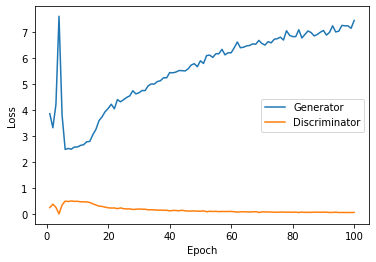

In [22]:
fig, ax = plt.subplots()
# 損失の推移を描画する。
ax.plot(history["epoch"], history["G_loss"], label="Generator")
ax.plot(history["epoch"], history["D_loss"], label="Discriminator")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()
plt.show()
fig.savefig("loss_new.png", facecolor="white")

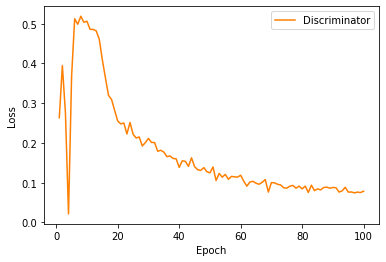

In [23]:
plt.plot(history["epoch"], history["D_loss"], color='#ff7f00',label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig("D_loss_new.png", facecolor="white")
plt.show()

## - Show Generating Images

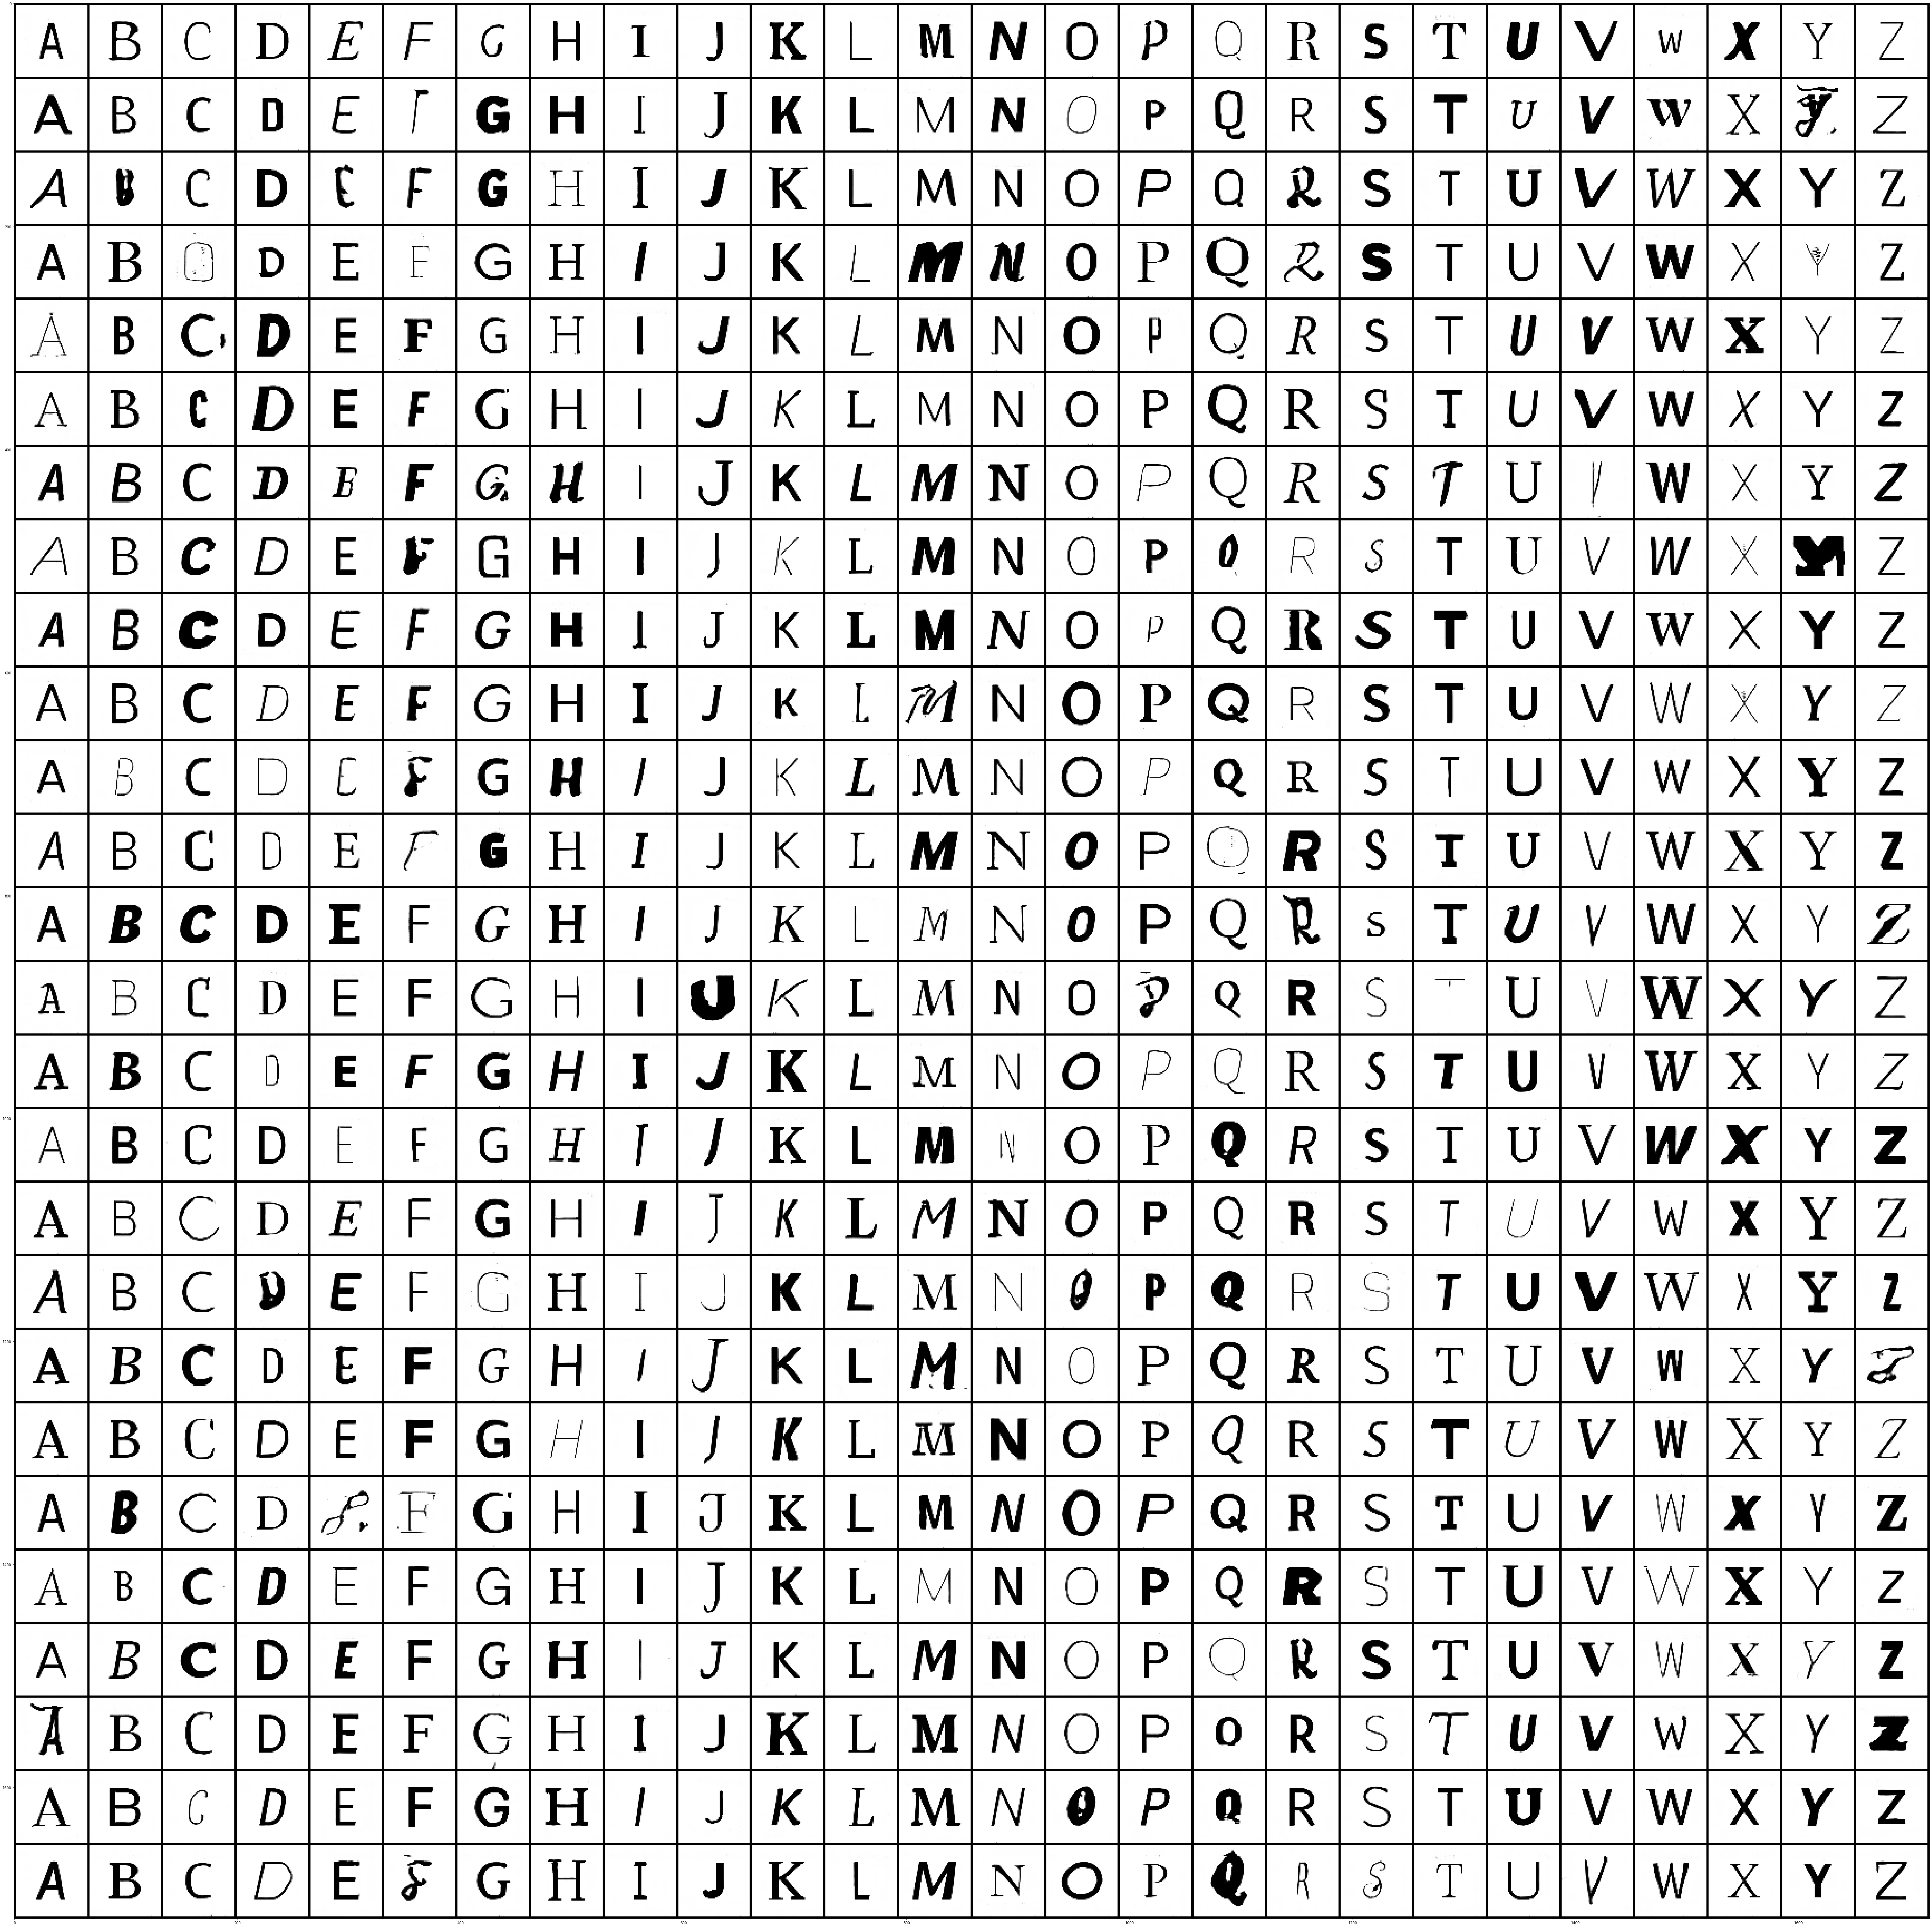

In [24]:
# Building z
# z1 = torch.rand((z_size, z_size))
# z2 = (torch.randn((z_size, z_size)) > 0) * 2 - 1
# z = Variable(torch.mul(z1, z2)).to(device) 
z = Variable(torch.randn(class_num * class_num, z_size, 1, 1)).to(device)

# Labels 0 ~ 9
labels = Variable(torch.LongTensor([i for _ in range(class_num) for i in range(class_num)])).to(device)

# Generating images
sample_images = generator(z, labels).data.cpu()

# Show images
grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(100,100))
ax.imshow(grid)
fig.savefig('GAN_sample_new.png')
# plt.yticks([])
# plt.xticks(np.arange(15, 300, 30), class_list, rotation=45, fontsize=20)
